# More quadrature by expansion (QBX) examples for the Laplace equation: fun with screw dislocations

## Antiplane shear

A basic result in linear elastic earthquake modeling is the infinitely long strike-slip fault. Because the fault is infinitely long, all displacements is fault parallel. This results in a displacement and strain state like:

$$ \vec{u} = (0, 0, u_3) $$
$$ \boldsymbol{\varepsilon} = \begin{bmatrix}
0 & 0 & \epsilon_{13} \\
0 & 0 & \epsilon_{23}\\
 \epsilon_{13}    &    \epsilon_{23}      & 0\end{bmatrix} $$
 
This special state is called "antiplane shear". If we simplify the elasticity equations to this setting, we get the result that $u_3$ is a solution to the Laplace equation:

$$ \nabla^2 u_3 = 0 $$

As a result, we can describe solutions to the Laplace equation in terms of the elastic behavior of infinitely long strike-slip faults (aka a "screw dislocation"). 

Below, we're going to use QBX to compute the displacements and stresses resulting from slip on infinitely long strike-slip faults with fun shapes. In particular, the "double layer" integral we computed in part 1 will translate slip on the fault into a displacement value in the volume. We'll introduce the "hypersingular" integral to calculate stresses from slip.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

I've moved the functions we wrote in the previous part into `common.py`. We'll import them!

In [2]:
from common import gauss_rule, double_layer_matrix, qbx_choose_centers, qbx_expand_matrix, qbx_interior_eval

## Barycentric Lagrange interpolation

When we compute a boundary integral, there are two sources of error: the surface approximation error and the quadrature error. We've been focusing here on the quadrature error because it can be reduced dramatically with better algorithms (QBX!). The surface approximation error is handled simply through using a higher resolution approximation to the surface -- for example, represent a circle with 100 points instead of 50. However, below, it will be nice to be able to hold the surface approximation error constant while reducing the quadrature error to zero. But, in the integration techniques we have been using, the quadrature error and the surface error are inextricably linked. When we increase from using 50 to 100 points to integrate a function over a circle, we have been improving both the surface approximation and also using a more accurate quadrature rule. 

To separate the two components, we'll interpolate points from a low order surface approximation in order to calculate the locations of quadrature points for a higher order integral approximation. To make the difference more concrete... Before, we would calculate new point locations for a circle by calculating $(cos \theta, sin \theta)$. Now, we will calculate the new point from a polynomial interpolation of the $n$ existing points $\sum_{i}^n c_i p_i(x)$. In some sense, this is also more realistic. In a real-world application, we normally have a data-derived surface representation that we can't improve. On the other hand, we *can* add more quadrature points by interpolating on that surface, but that won't make the surface itself any more accurate.

To do this, it's going to be helpful to have some functions for interpolation! This snippet of code below is an implementation of [barycentric Lagrange interpolation](https://people.maths.ox.ac.uk/trefethen/barycentric.pdf){cite:p}`Berrut2004`. I strongly recommend that paper if you've never run into barycentric Lagrange interpolation before!

In [3]:
def interp_weights(x):
    dist = x[:, None] - x[None, :]
    np.fill_diagonal(dist, 1.0)
    weights = 1.0 / np.prod(dist, axis=1)
    return weights

def barycentric_eval(eval_pts, interp_pts, interp_wts, fnc_vals):
    dist = eval_pts[:, None] - interp_pts[None, :]
    kernel = interp_wts[None, :] / dist
    return (kernel.dot(fnc_vals)) / np.sum(kernel, axis=1)

Below is a little check to make sure our interpolation snippet is working correctly. We interpolate $sin(5x)$ (plotted with a solid black line) on a grid of 7 points (blue dots) and plot the resulting approximate function (red dashes line). This isn't a rigorous check, but it seems like it's working! Convergence is very fast if we increase the interpolation order, but I've left out a demonstration of that.

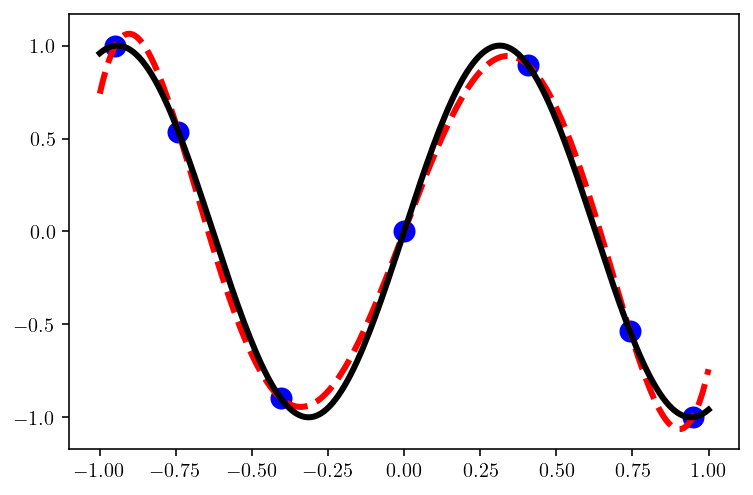

In [4]:
qx, qw = gauss_rule(7)
gauss_interp_wts = interp_weights(qx)
xs = np.linspace(-1, 1, 200)
fqx = np.sin(5 * qx)
v = barycentric_eval(xs, qx, gauss_interp_wts, fqx)
plt.plot(qx, fqx, 'bo', markersize=10)
plt.plot(xs, v, 'r--')
plt.plot(xs, np.sin(5 * xs), 'k-')
plt.show()

Let's also have a couple helper functions for interpolating functions and surface.

In [5]:
def interp_fnc(f, in_xhat, out_xhat):
    iw = interp_weights(in_xhat)
    return barycentric_eval(out_xhat, in_xhat, iw, f)

def interp_surface(in_surf, in_xhat, out_xhat):
    out = []
    for f in in_surf[:5]:
        out.append(interp_fnc(f, in_xhat, out_xhat))
    return out

## Hypersingular stress integrals

The second missing piece is a naive integrator for the hypersingular integral! In earthquake speak, still operating in the antiplane setting, since we set the observation point normal to $(1, 0)$, we're computing the stress component $\sigma_{xz}$. If we set the observation normal to $(0, 1)$, we would compute $\sigma_{yz}$. (Note: I'm also implicitly assuming the shear modulus $\mu = 1$.) 

Since, we already built all the components of an algorithm for the double layer case, we can now just write this naive integrator for a new kernel and everything works perfectly. 

Why is this kernel called "hypersingular"? Because the kernel behaves like $O(\frac{1}{r^2})$ in 2D. This makes the integral especially difficult. As you'll see below, this is not a barrier for QBX and we are able to calculate the integral extremely accurately even right on the surface.

In [6]:
def hypersingular_matrix(surface, quad_rule, obsx, obsy):
    srcx, srcy, srcnx, srcny, curve_jacobian = surface

    dx = obsx[:, None] - srcx[None, :]
    dy = obsy[:, None] - srcy[None, :]
    r2 = dx ** 2 + dy ** 2
    
    obsny = 0.0 * obsx
    obsnx = np.full_like(obsx, 1.0)
    
    srcn_dot_obsn = srcnx[None, :] * obsnx[:, None] + srcny[None, :] * obsny[:, None]
    d_dot_srcn = dx * srcnx[None, :] + dy * srcny[None, :]
    d_dot_obsn = dx * obsnx[:, None] + dy * obsny[:, None]
    
    # The definition of the hypersingular kernel.
    integrand = (srcn_dot_obsn - (2 * d_dot_srcn * d_dot_obsn / r2)) / (2 * np.pi * r2)

    return integrand * curve_jacobian * quad_rule[1][None, :]

Finally, I'll write a pretty big function that is going to produce nice figures for comparing QBX against a naive computation. The function is written to be independent of the surface and kernel function. It also accepts QBX parameters. As a reminder, `offset_mult` is a multiplier for how far off the surface the QBX expansion centers are placed. `kappa` is the upsampling rate in case we want to use a higher order quadrature for computing QBX coefficients than for representing the surface. And `qbx_p` is the order of the power series expansion. Please look through the function! Very little is new compared to Part 1.

In [7]:
def qbx_example(kernel, surface_fnc, n, offset_mult, kappa, qbx_p):
    
    def slip_fnc(xhat):
        # This must be zero at the endpoints!
        return np.cos(xhat * np.pi) + 1.0
    
    quad_rule_low = gauss_rule(n)
    surface_low = surface_fnc(quad_rule_low[0])
    slip_low = slip_fnc(surface_low[0])
    
    nobs = 400
    zoomx = [-1.5, 1.5]
    zoomy = [-1.5, 1.5]
    xs = np.linspace(*zoomx, nobs)
    ys = np.linspace(*zoomy, nobs)
    obsx, obsy = np.meshgrid(xs, ys)

    disp_low = kernel(
        surface   = surface_low,
        obsx      = obsx.flatten(), 
        obsy      = obsy.flatten(),
        quad_rule = quad_rule_low
    ).dot(slip_low).reshape(obsx.shape)

    n = 2000
    quad_rule_high = gauss_rule(n)
    surface_high = interp_surface(surface_low, quad_rule_low[0], quad_rule_high[0])
    slip_high = interp_fnc(slip_low, quad_rule_low[0], quad_rule_high[0])
    disp_high = kernel(
        surface   = surface_high,
        obsx      = obsx.flatten(), 
        obsy      = obsy.flatten(),
        quad_rule = quad_rule_high
    ).dot(slip_high).reshape(obsx.shape)

    n = surface_low[0].shape[0] * kappa
    quad_rule_qbx = gauss_rule(n)
    surface_qbx = interp_surface(surface_low, quad_rule_low[0], quad_rule_qbx[0])
    slip_qbx = interp_fnc(slip_low, quad_rule_low[0], quad_rule_qbx[0])

    # This is new! We'll have two sets of QBX expansion centers on each side 
    # of the surface. The direction parameter simply multiplies the surface 
    # offset. So, -1 put the expansion the same distance on the other side
    # of the surface.
    qbx_center_x1, qbx_center_y1, qbx_r1 = qbx_choose_centers(
        surface_low, quad_rule_low, mult = offset_mult, direction = 1.0
    )
    qbx_center_x2, qbx_center_y2, qbx_r2 = qbx_choose_centers(
        surface_low, quad_rule_low, mult = offset_mult, direction = -1.0
    )
    qbx_center_x = np.concatenate([qbx_center_x1, qbx_center_x2])
    qbx_center_y = np.concatenate([qbx_center_y1, qbx_center_y2])
    qbx_r = np.concatenate([qbx_r1, qbx_r2])

    plt.plot(surface_qbx[0], surface_qbx[1], 'k-')
    plt.plot(qbx_center_x, qbx_center_y, 'r.')
    plt.show()

    Qexpand = qbx_expand_matrix(kernel, surface_qbx, quad_rule_qbx, qbx_center_x, qbx_center_y, qbx_r, qbx_p = qbx_p)
    qbx_coeffs = Qexpand.dot(slip_qbx)
    disp_qbx = qbx_interior_eval(
        kernel, 
        surface_low, 
        quad_rule_low, 
        slip_low, 
        obsx, 
        obsy, 
        qbx_center_x, 
        qbx_center_y, 
        qbx_r, 
        qbx_coeffs
    )

    plt.figure(figsize=(16,12))
    plt.subplot(2, 3, 1)
    plt.title('Naive solution')
    levels = np.linspace(-1.0,1.0,11)
    cntf = plt.contourf(obsx, obsy, disp_low, levels = levels, extend="both")
    plt.contour(obsx, obsy, disp_low, colors='k', linestyles='-', linewidths=0.5, levels = levels, extend="both")
    plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 2)
    plt.title('"Accurate" solution')
    cntf = plt.contourf(obsx, obsy, disp_high, levels = levels, extend="both")
    plt.contour(obsx, obsy, disp_high, colors='k', linestyles='-', linewidths=0.5, levels = levels, extend="both")
    plt.colorbar(cntf)
    plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 3)
    plt.title('Naive error')
    logerror = np.log10(np.abs(disp_low - disp_high))
    logerror[np.isinf(logerror)]=-12.0
    cntf = plt.contourf(obsx, obsy, logerror, levels = np.linspace(-12, 0, 13), extend="both")
    plt.contour(obsx, obsy, logerror, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-12, 0, 13), extend="both")
    cb = plt.colorbar(cntf)
    cb.set_label('$\log_{10}(|\hat{u} - \hat{u}_{\\textrm{naive}}|)$', fontsize=14)
    plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.tight_layout()

    plt.subplot(2, 3, 4)
    plt.title('QBX solution')
    cntf = plt.contourf(obsx, obsy, disp_qbx, levels = levels, extend="both")
    plt.contour(obsx, obsy, disp_qbx, colors='k', linestyles='-', linewidths=0.5, levels = levels, extend="both")
    plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 5)
    plt.title('"Accurate" solution')
    cntf = plt.contourf(obsx, obsy, disp_high, levels = levels, extend="both")
    plt.contour(obsx, obsy, disp_high, colors='k', linestyles='-', linewidths=0.5, levels = levels, extend="both")
    plt.colorbar(cntf)
    plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 6)
    plt.title('QBX error')
    logerror = np.log10(np.abs(disp_qbx - disp_high))
    logerror[np.isinf(logerror)]=-12.0
    cntf = plt.contourf(obsx, obsy, logerror, levels = np.linspace(-12, 0, 13), extend="both")
    plt.contour(obsx, obsy, logerror, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-12, 0, 13), extend="both")
    cb = plt.colorbar(cntf)
    cb.set_label('$\log_{10}(|\hat{u} - \hat{u}_{\\textrm{QBX}}|)$', fontsize=14)
    plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.tight_layout()
    plt.show()

## Displacement from a line source

For the remainder of this part, we'll compute displacements and stresses for a three simple geometries of increasing difficulty. 

For each plot, there will be a geometry summary that's just a black line showing the location of the "fault" and red dots showing the location of the QBX expansions. 

Then, we'll plot three solutions: the naive solution, a high accuracy naive solution (from 2000 points) and a QBX solution. We'll also plot the $\log_{10}$ error for both the naive and QBX solutions.

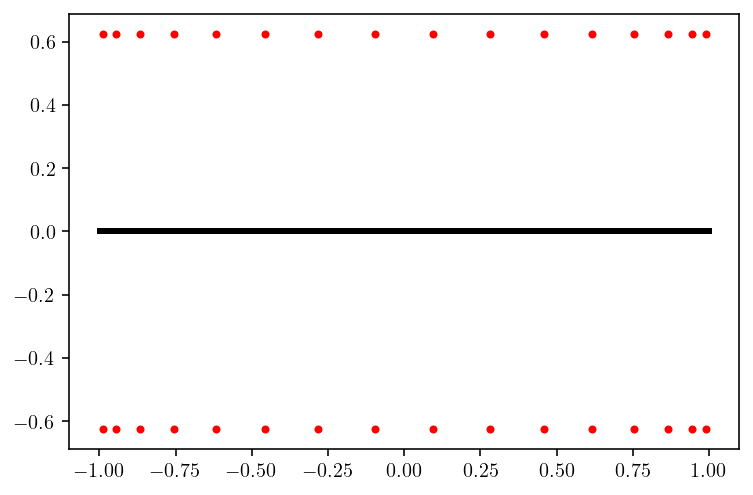

<ipython-input-7-4395429525d3>:95: RuntimeWarning: divide by zero encountered in log10
  logerror = np.log10(np.abs(disp_low - disp_high))


<ipython-input-7-4395429525d3>:125: RuntimeWarning: divide by zero encountered in log10
  logerror = np.log10(np.abs(disp_qbx - disp_high))


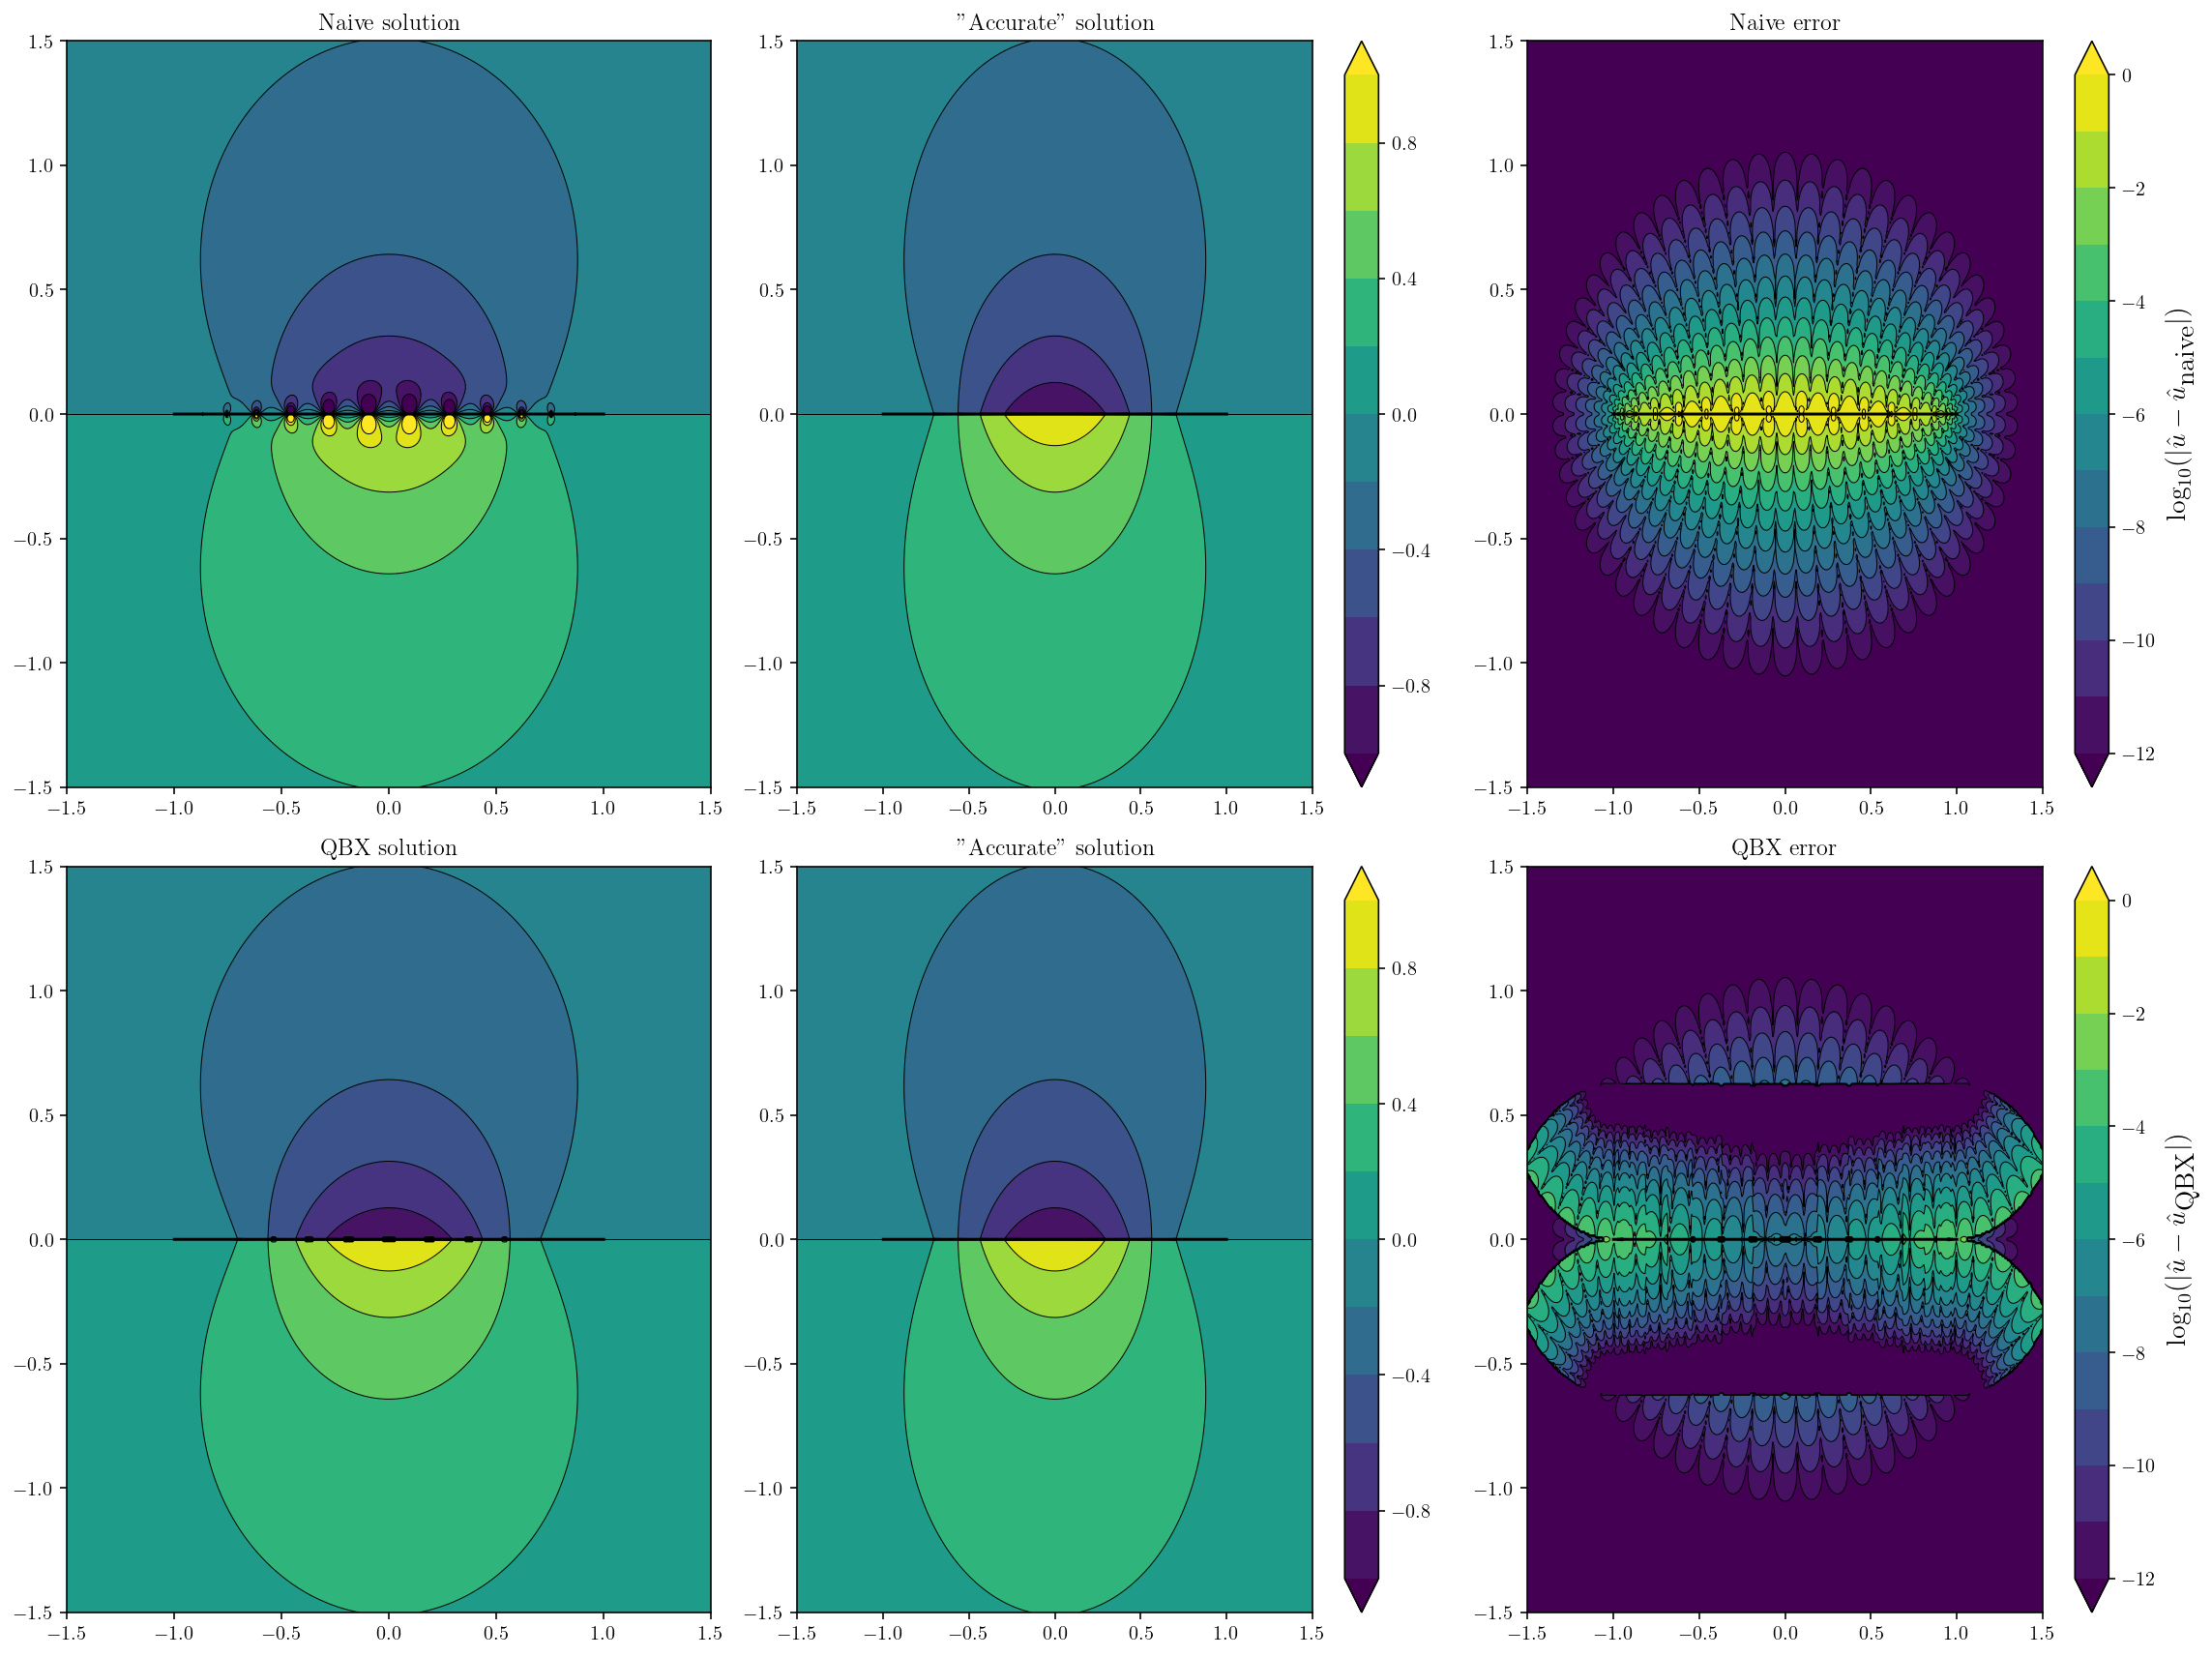

In [8]:
def line(q):
    # Remember the surface tuple format is:
    # (coord_x, coord_y, normal_x, normal_y, jacobian)
    return q, 0 * q, 0 * q, np.ones_like(q), np.ones_like(q)
qbx_example(double_layer_matrix, surface_fnc=line, n=16, offset_mult=5, kappa=3, qbx_p=15)

## Stress from a line source

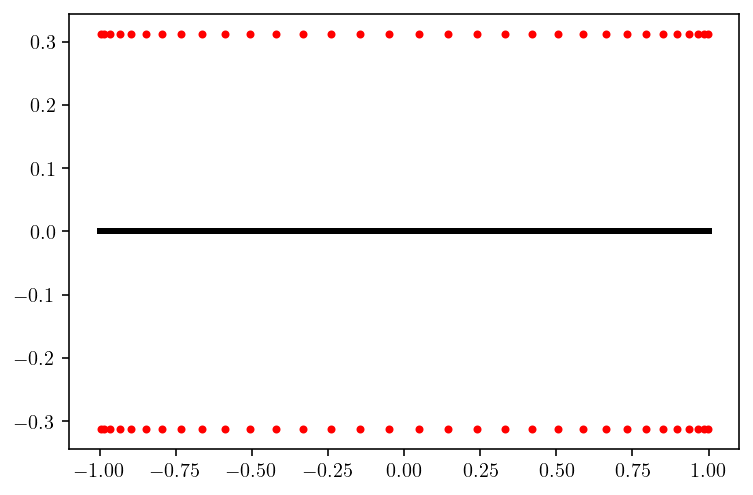

<ipython-input-7-4395429525d3>:95: RuntimeWarning: divide by zero encountered in log10
  logerror = np.log10(np.abs(disp_low - disp_high))


<ipython-input-7-4395429525d3>:125: RuntimeWarning: divide by zero encountered in log10
  logerror = np.log10(np.abs(disp_qbx - disp_high))


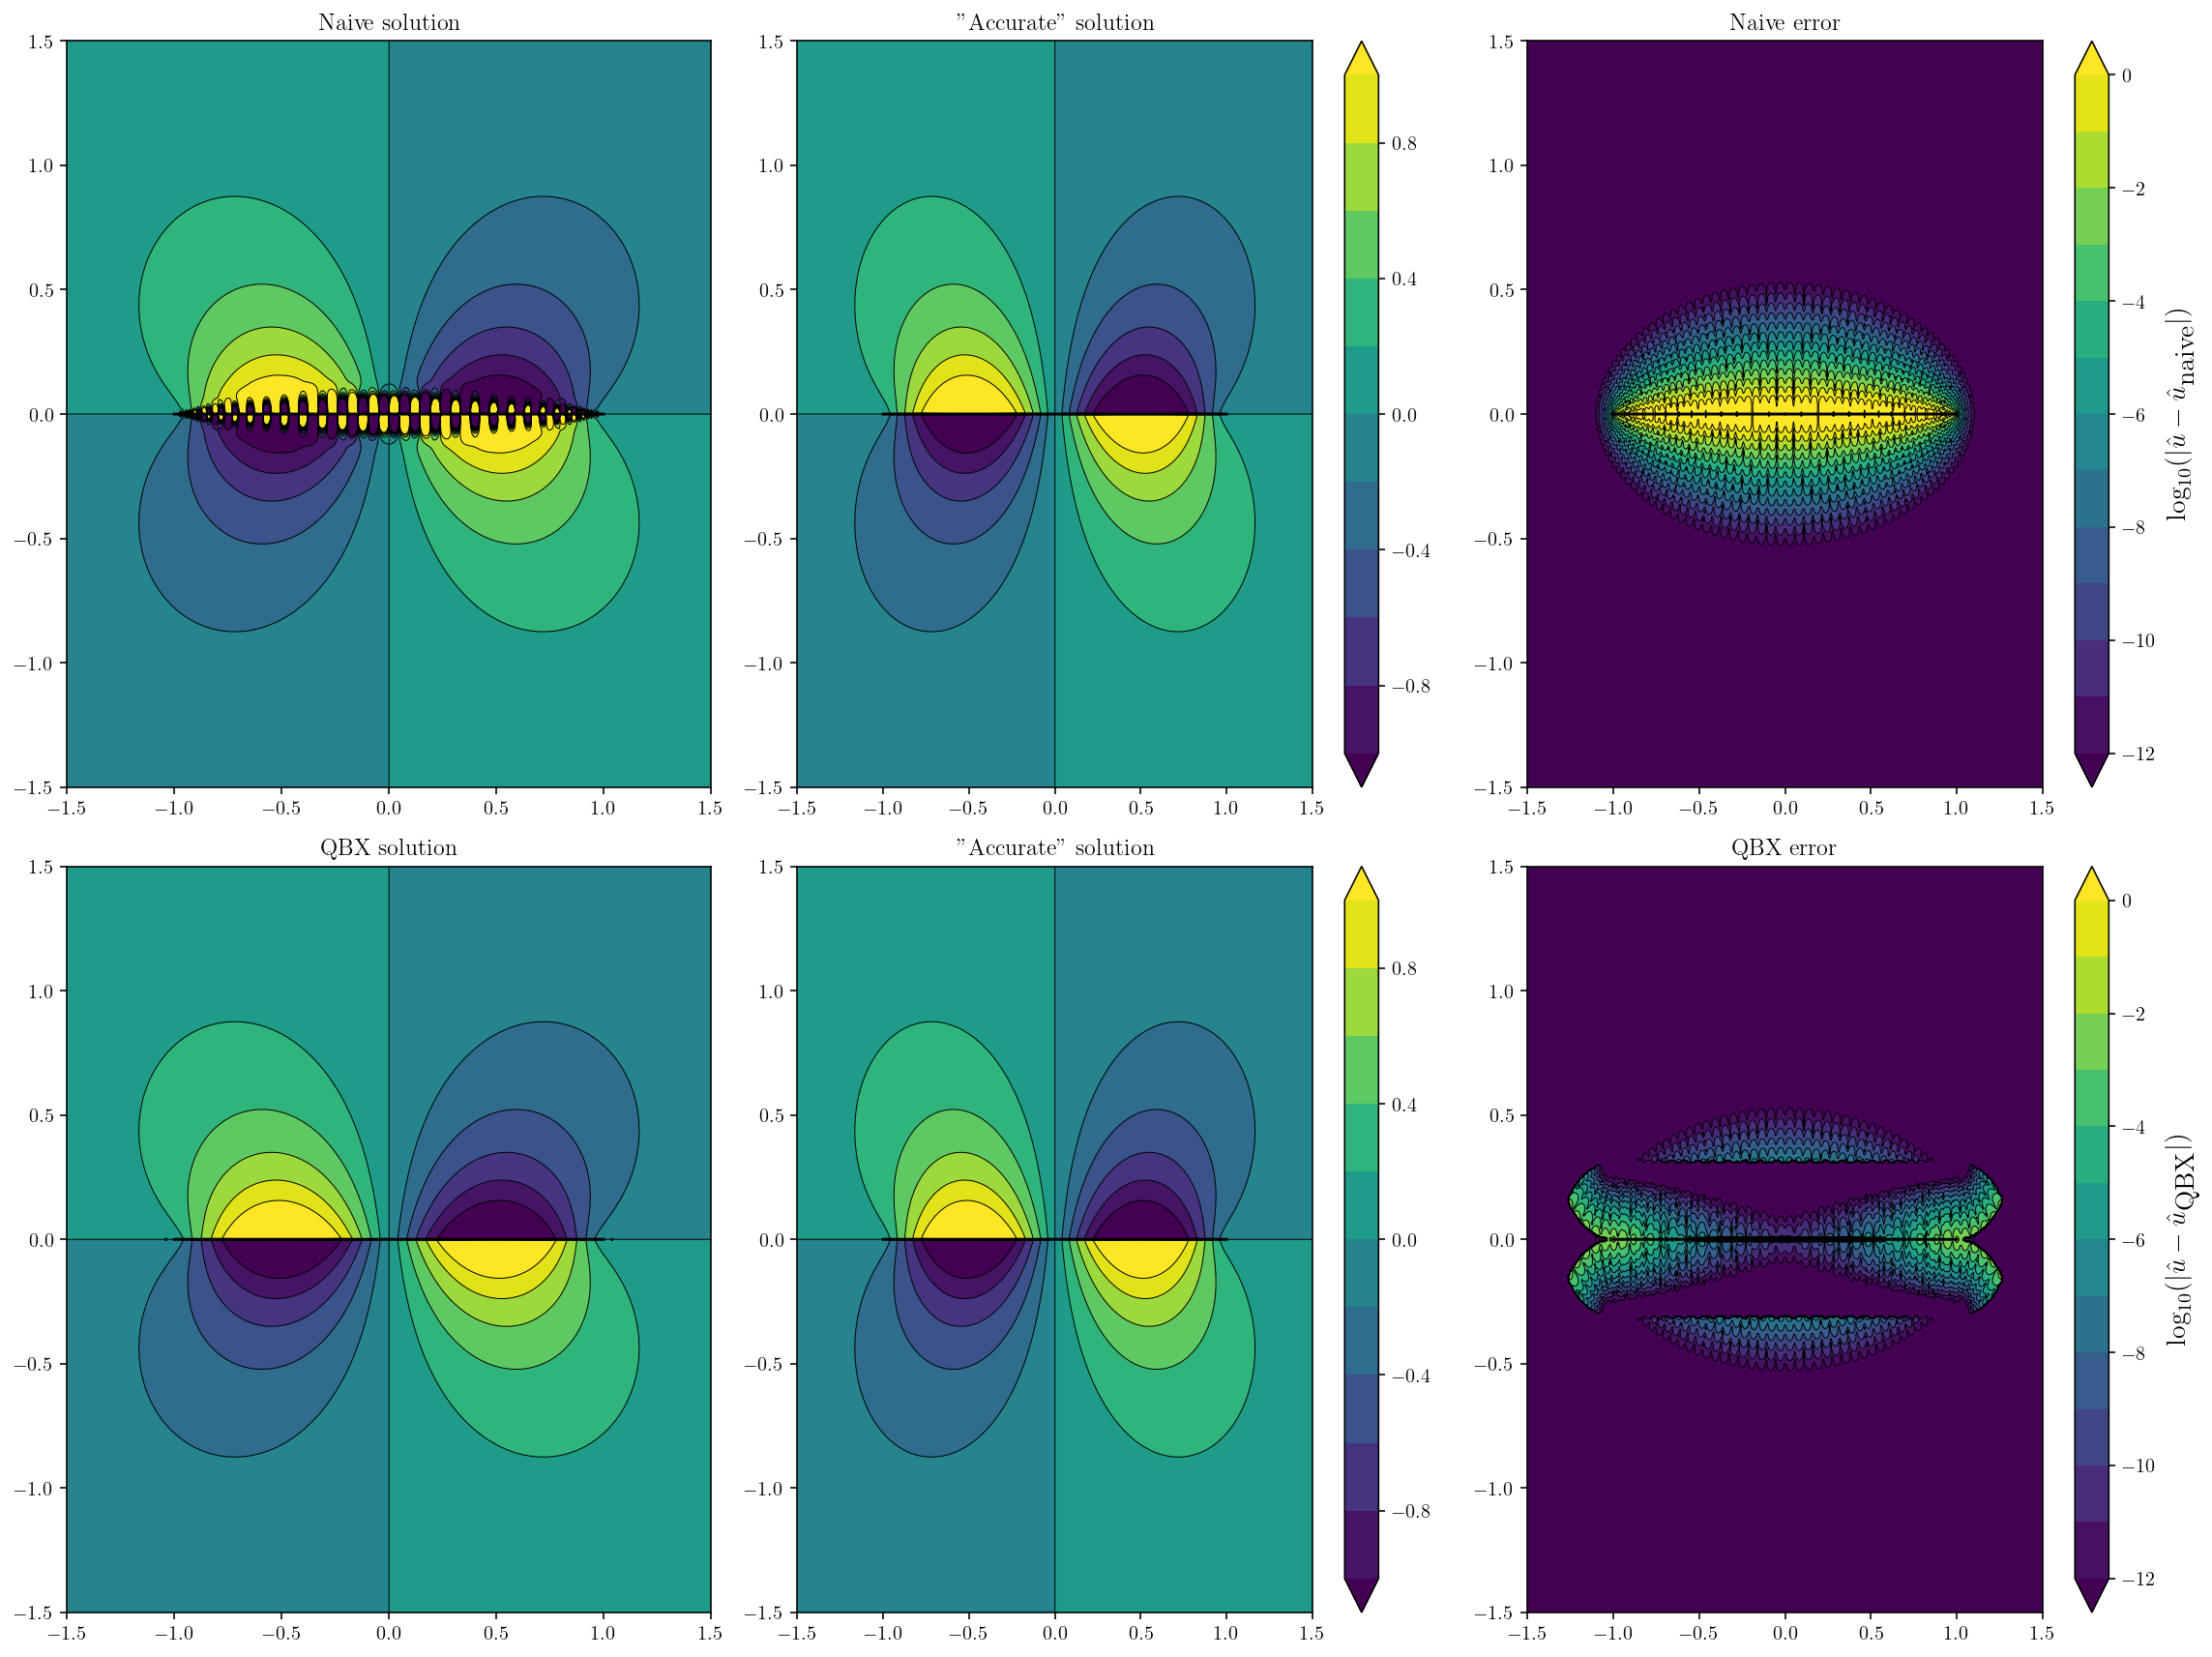

In [9]:
qbx_example(hypersingular_matrix, surface_fnc=line, n=32, offset_mult=5, kappa=5, qbx_p=15)

## Displacement from an arc source

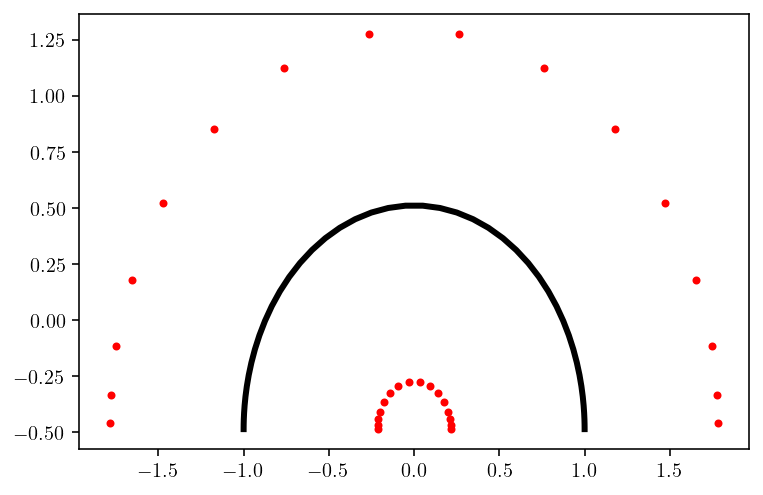

<ipython-input-7-4395429525d3>:95: RuntimeWarning: divide by zero encountered in log10
  logerror = np.log10(np.abs(disp_low - disp_high))


<ipython-input-7-4395429525d3>:125: RuntimeWarning: divide by zero encountered in log10
  logerror = np.log10(np.abs(disp_qbx - disp_high))


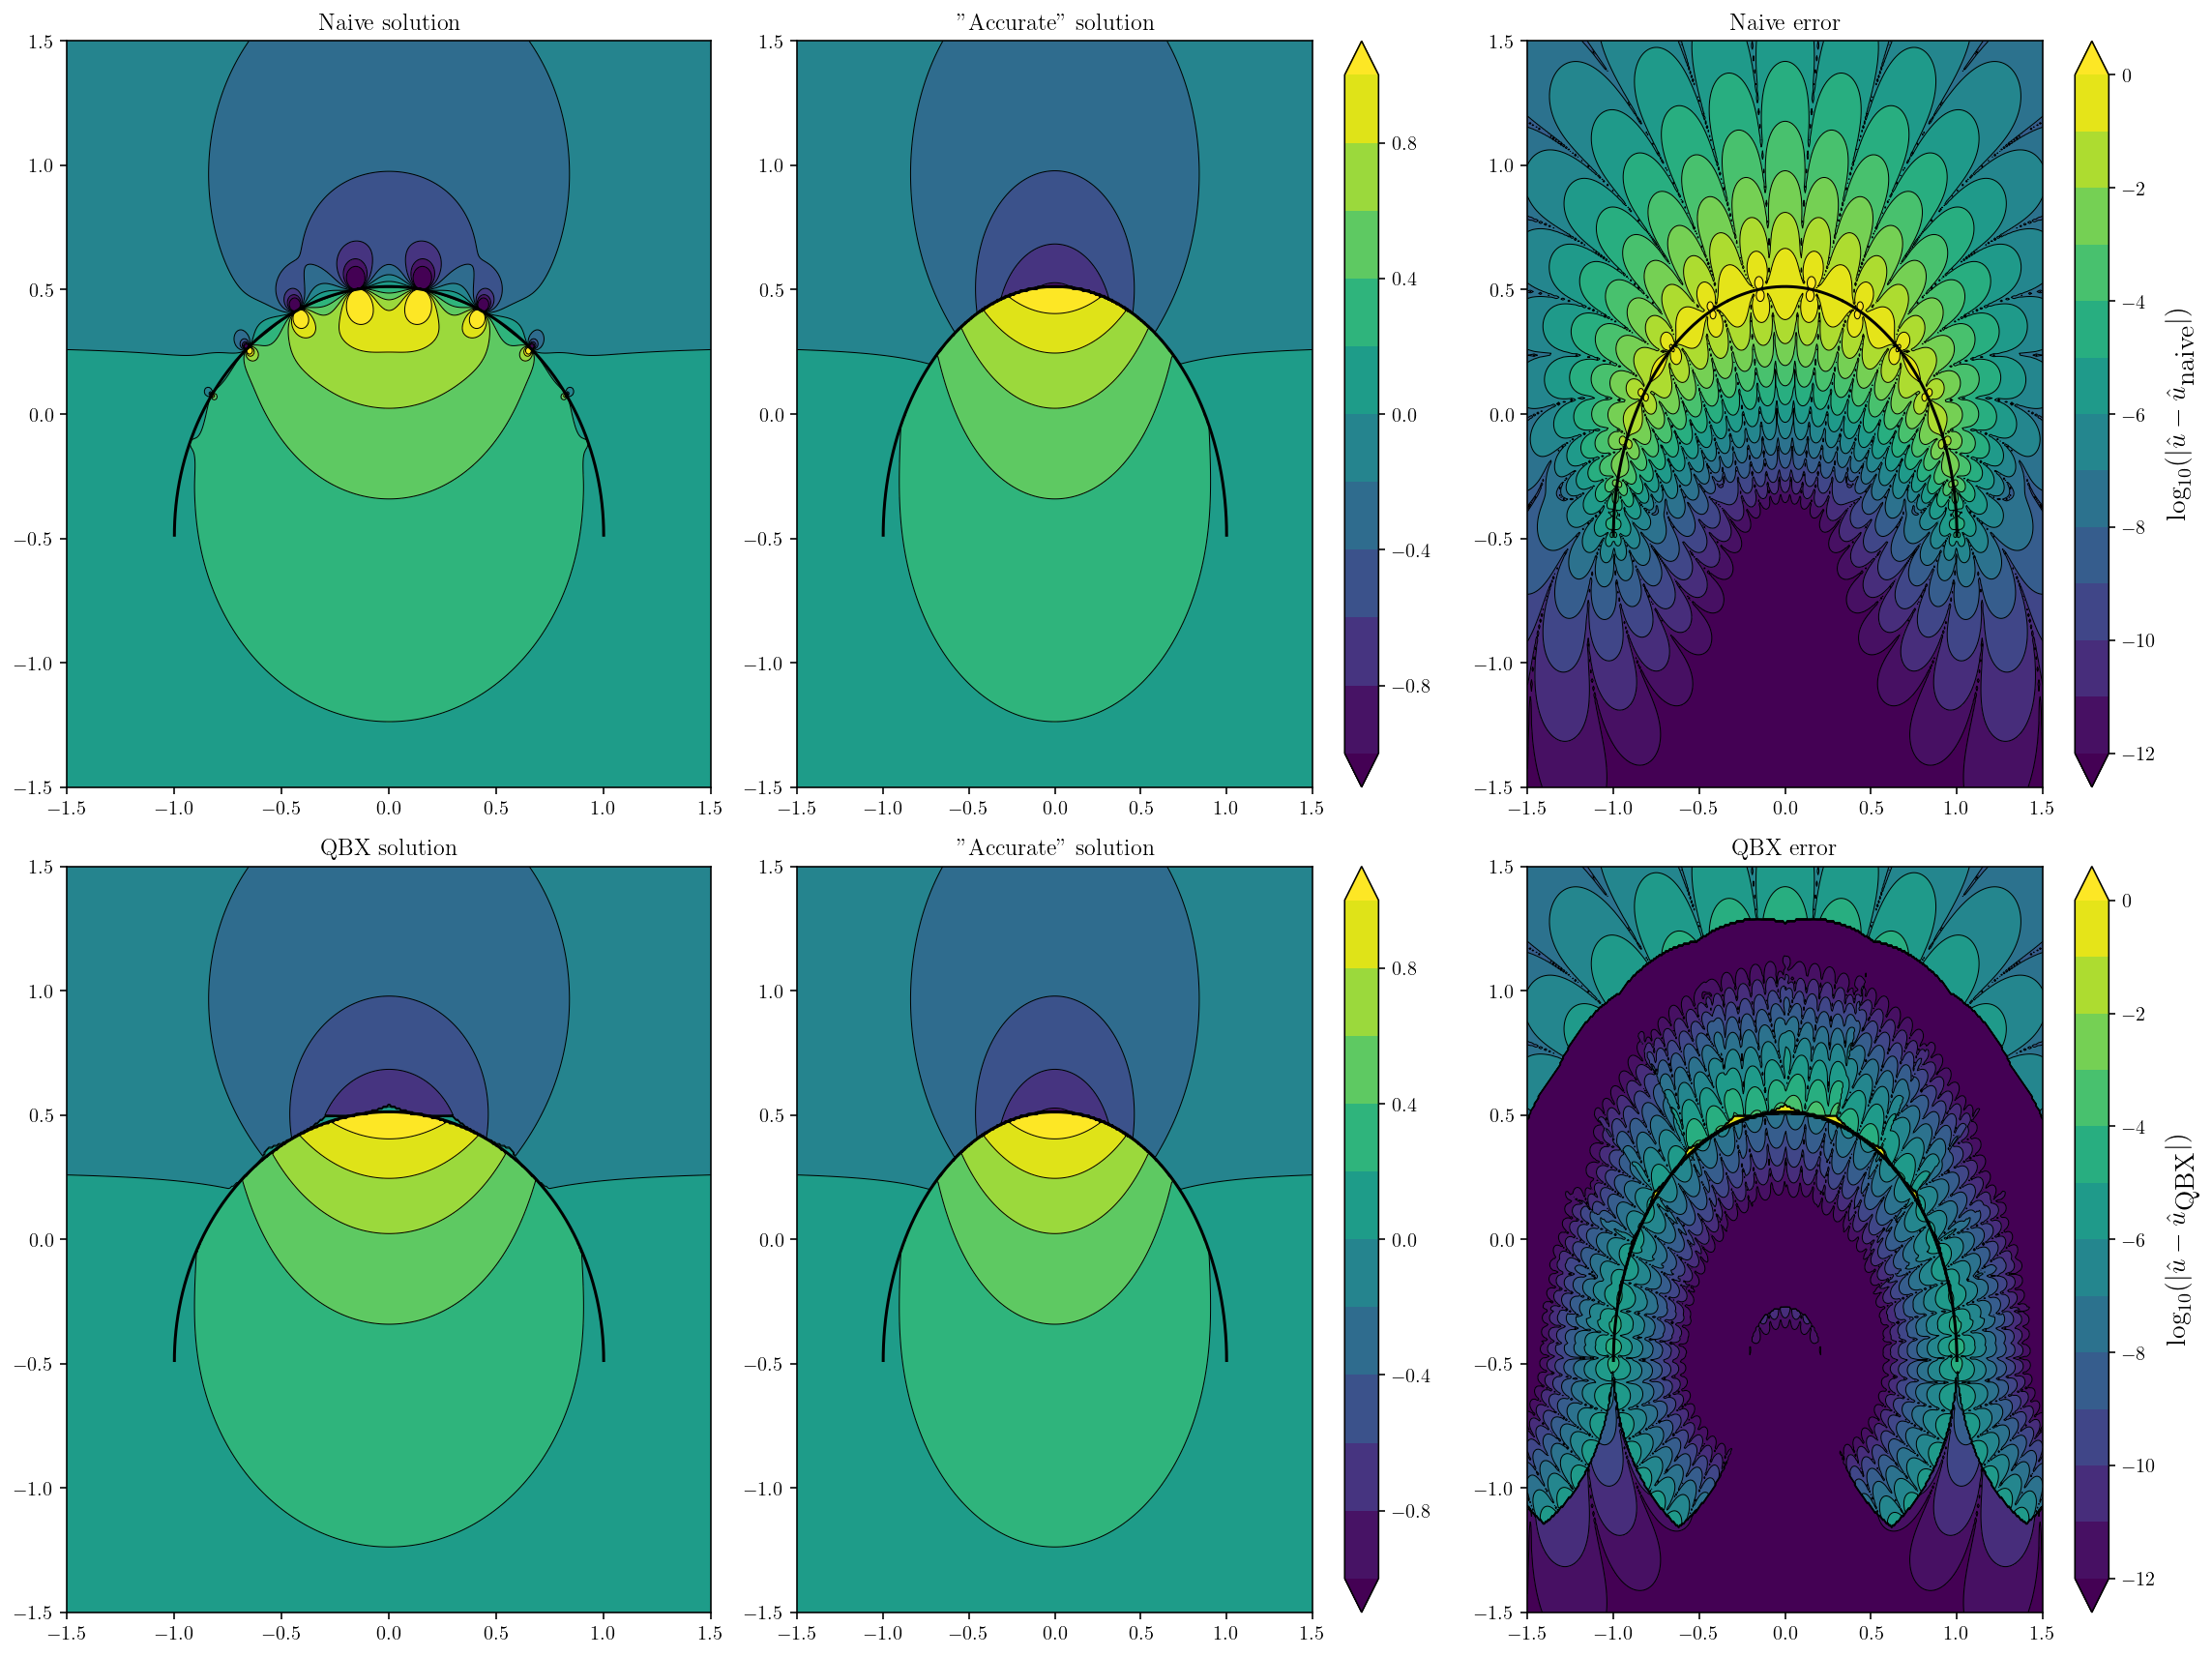

In [10]:
def arc(q):
    t = 0.5 * np.pi * q + 0.5 * np.pi
    x = np.cos(t)
    y = np.sin(t)
    nx = x.copy()
    ny = y.copy()
    y -= np.mean(y)
    return x, y, nx, ny, np.full_like(x, 0.5 * np.pi)
qbx_example(double_layer_matrix, surface_fnc=arc, n=16, offset_mult=4, kappa=3, qbx_p=20)

## Stress from an arc source

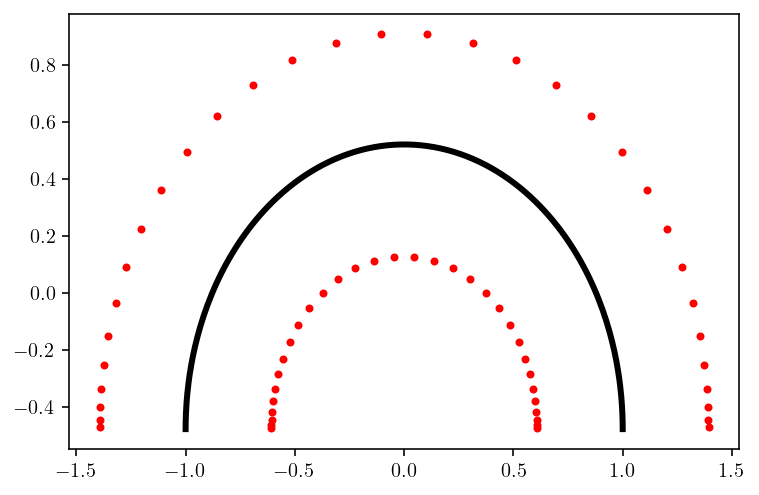

<ipython-input-7-4395429525d3>:95: RuntimeWarning: divide by zero encountered in log10
  logerror = np.log10(np.abs(disp_low - disp_high))


<ipython-input-7-4395429525d3>:125: RuntimeWarning: divide by zero encountered in log10
  logerror = np.log10(np.abs(disp_qbx - disp_high))


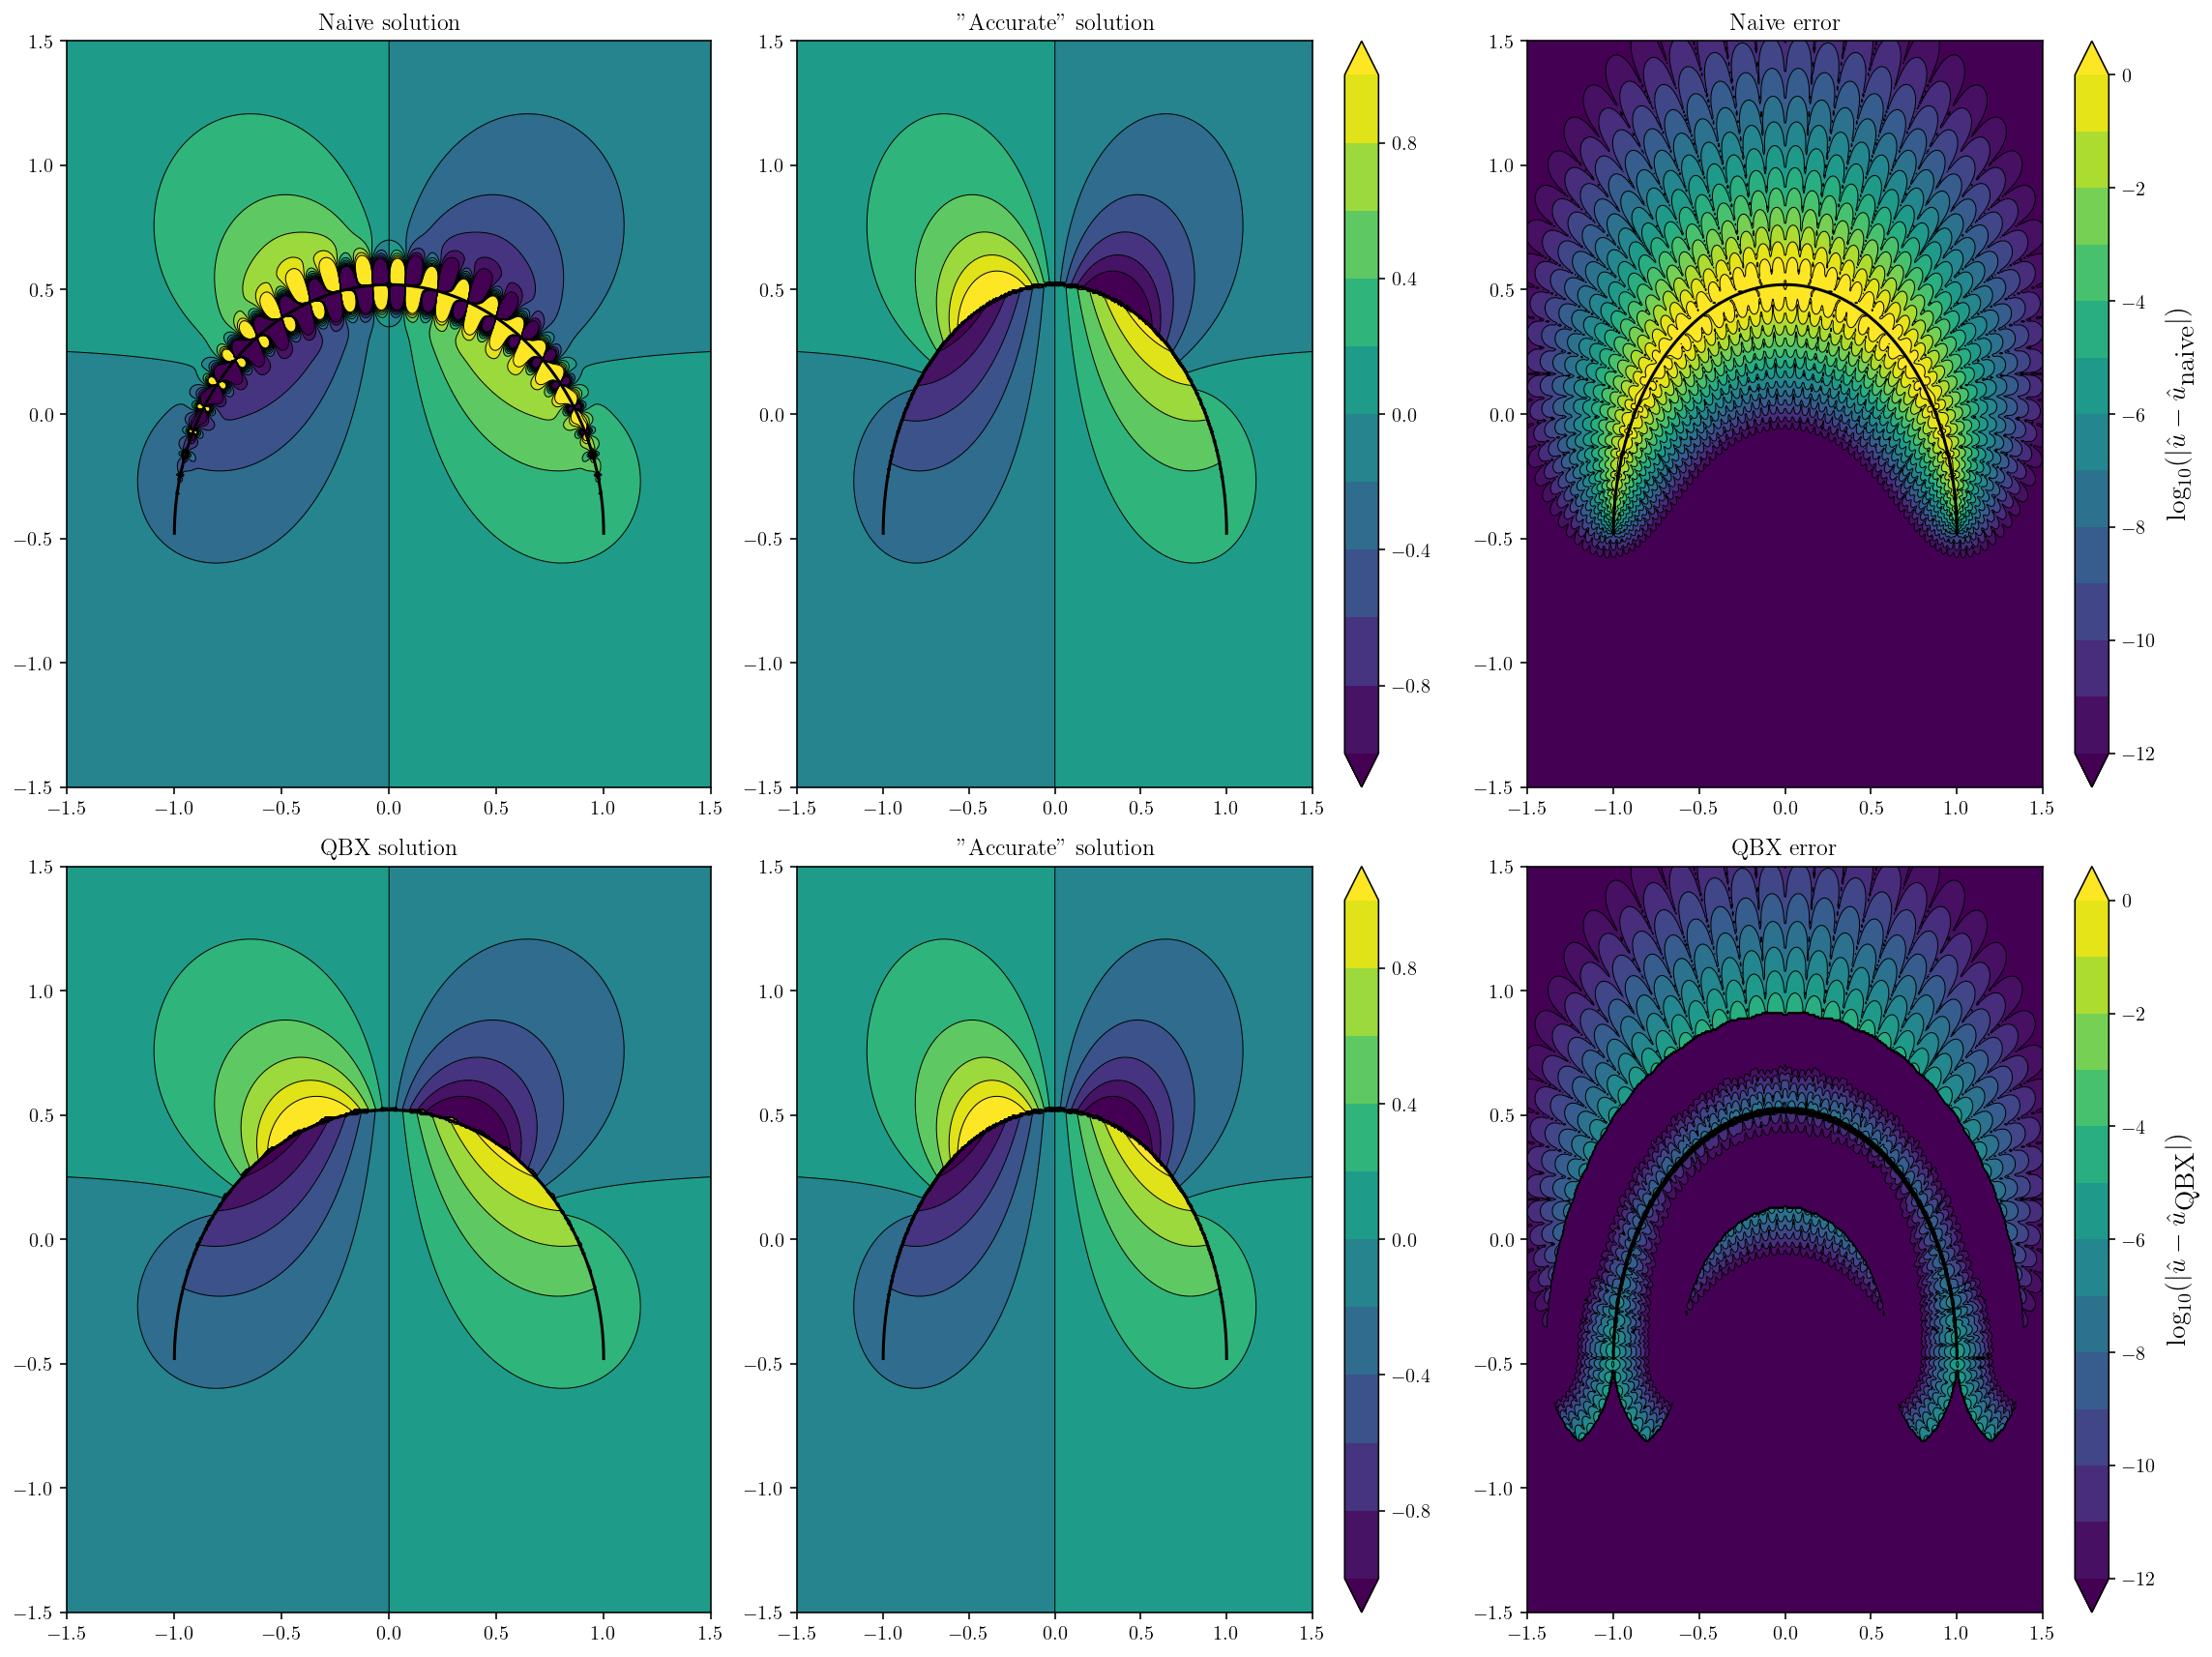

In [11]:
qbx_example(hypersingular_matrix, surface_fnc=arc, n=32, offset_mult=4, kappa=5, qbx_p=20)

## Displacement from a challenging wavy source

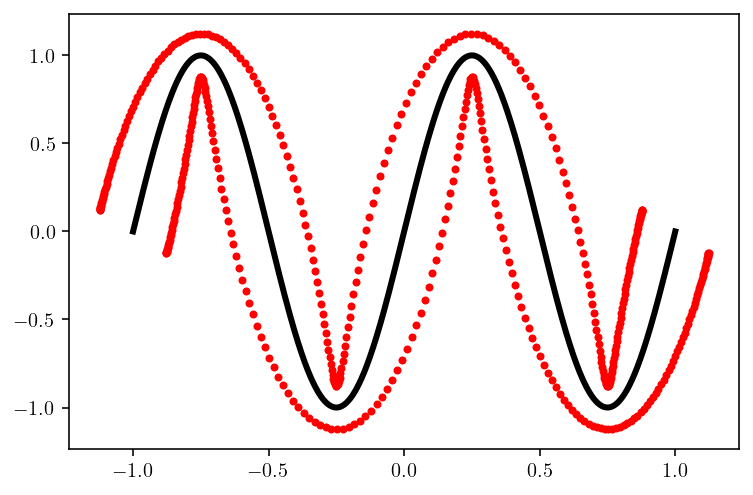

<ipython-input-7-4395429525d3>:95: RuntimeWarning: divide by zero encountered in log10
  logerror = np.log10(np.abs(disp_low - disp_high))


<ipython-input-7-4395429525d3>:125: RuntimeWarning: divide by zero encountered in log10
  logerror = np.log10(np.abs(disp_qbx - disp_high))


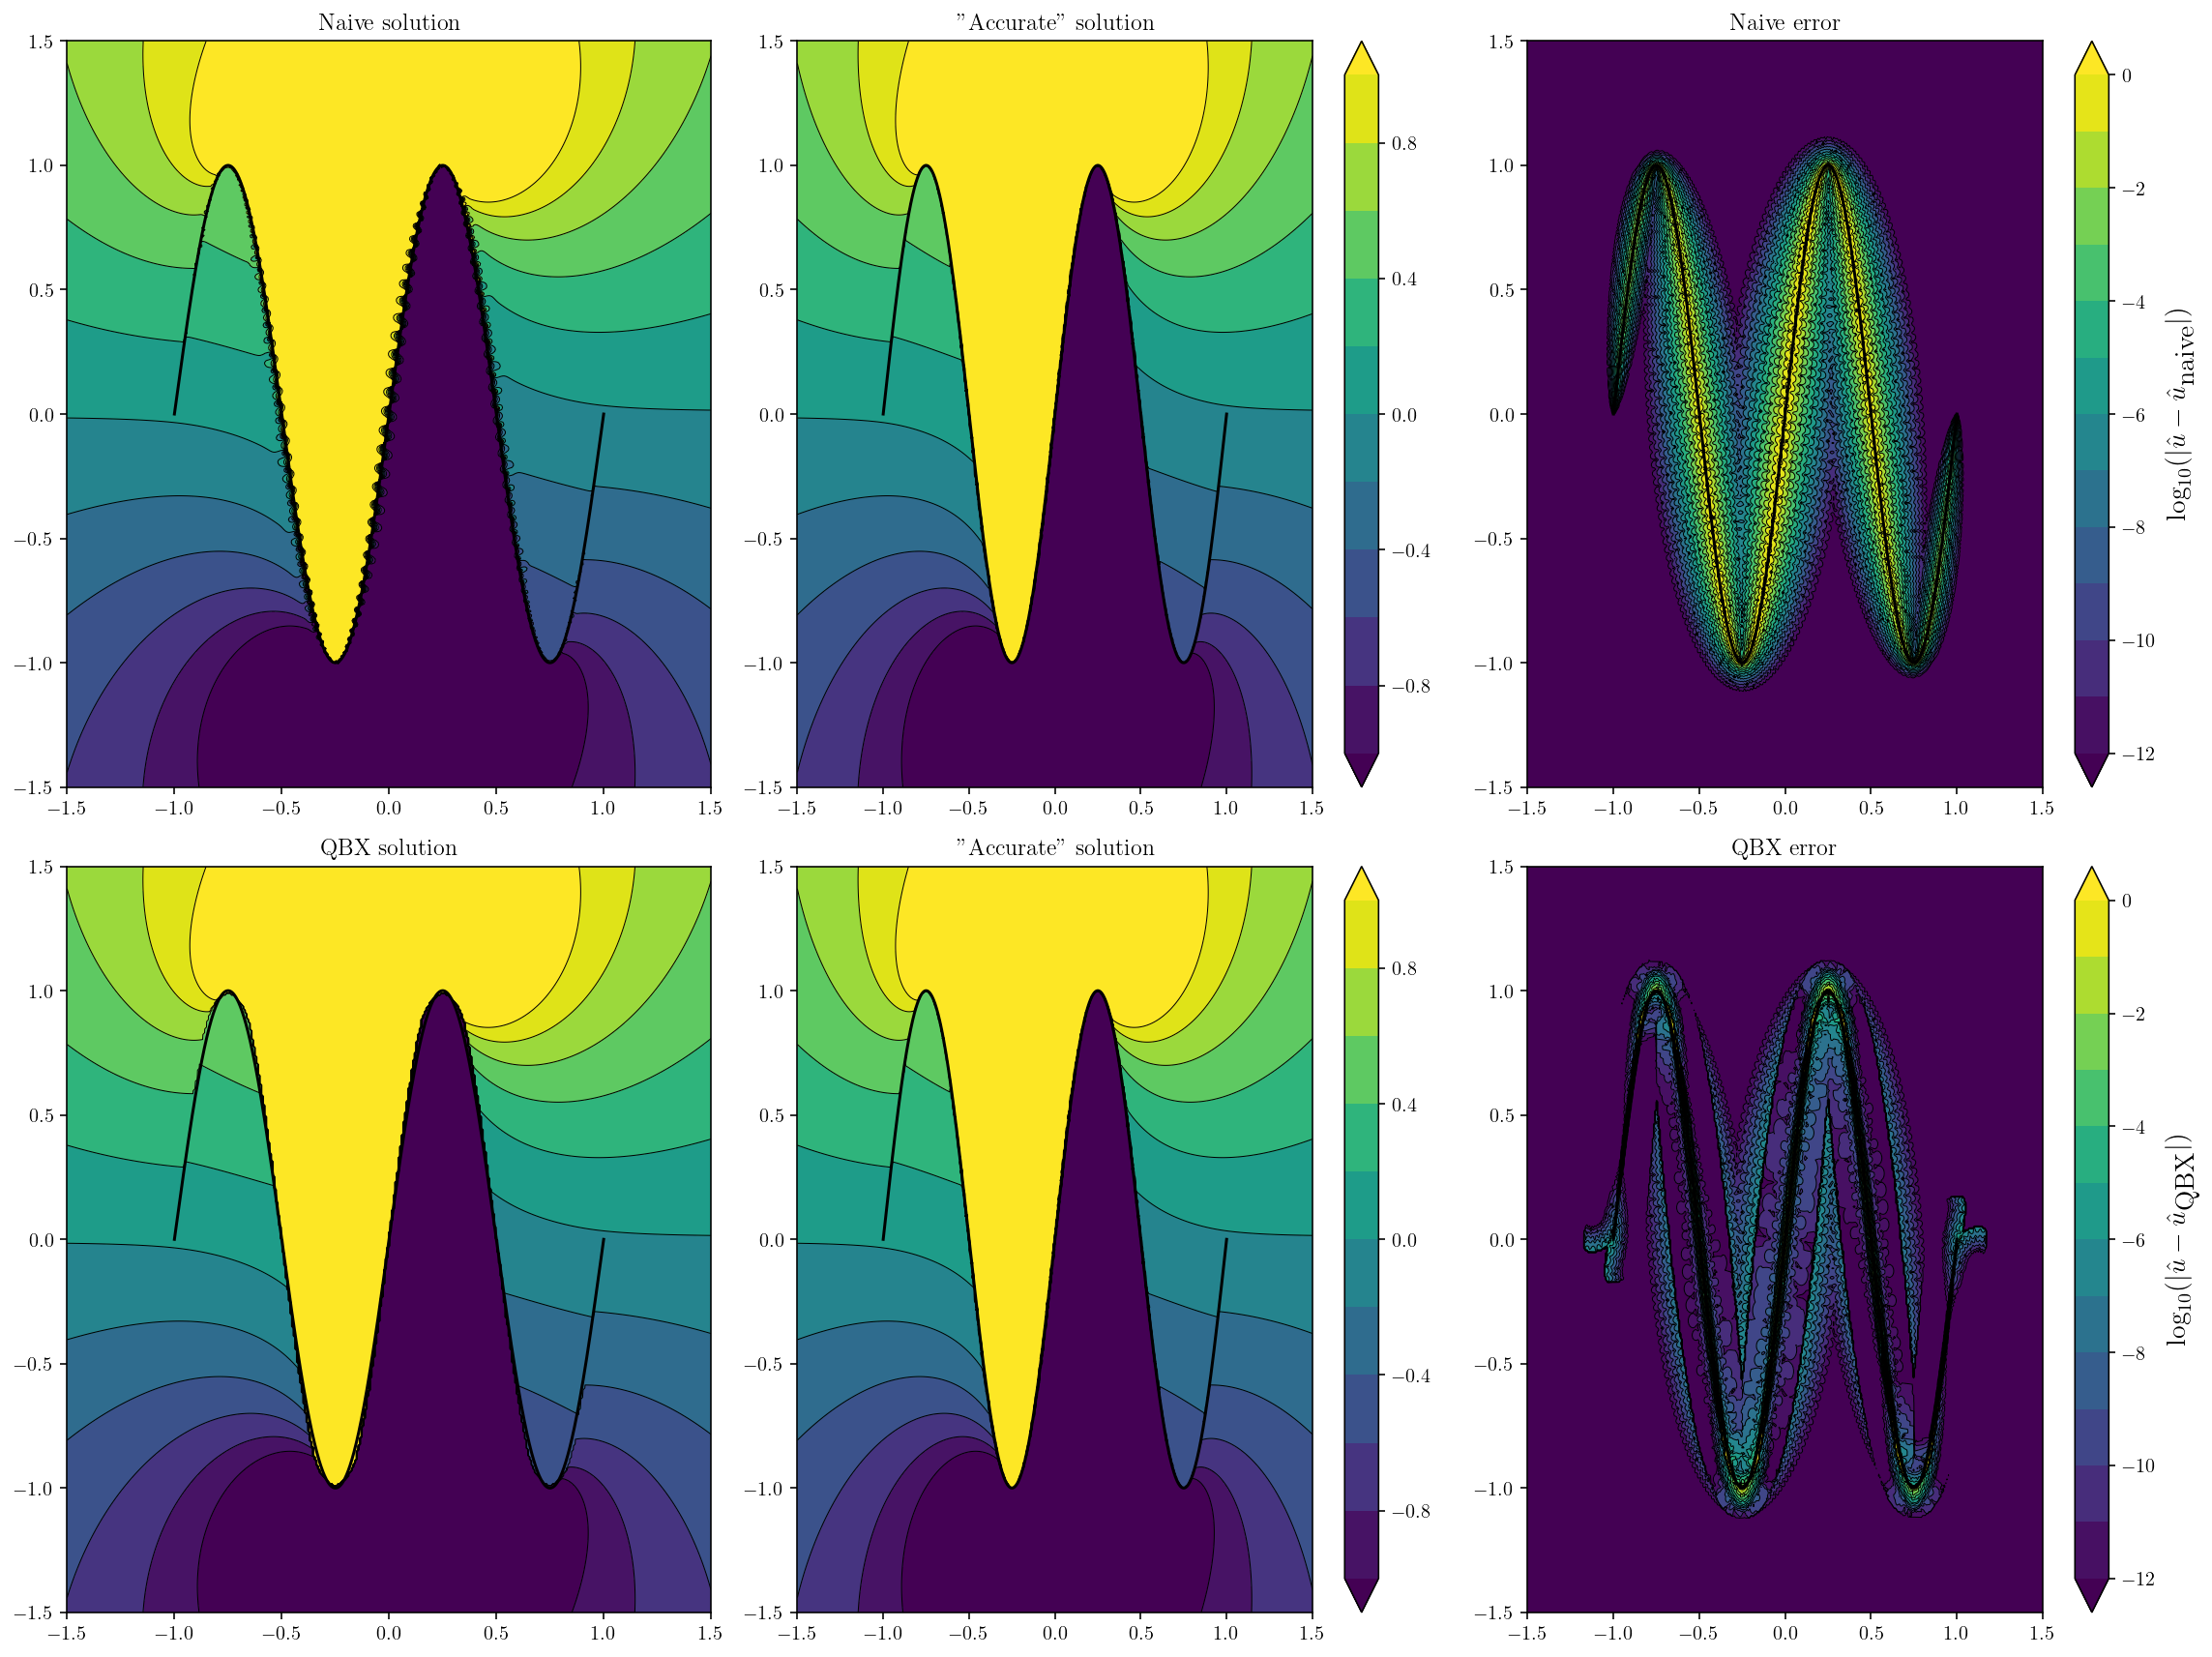

In [12]:
def wavy(q):
    t = (q + 1) * 2 * np.pi
    x, y = q, np.sin(t)
    
    dxdt = 1.0
    dydt = np.cos(t)
    ddt_norm = np.sqrt(dxdt ** 2 + dydt ** 2)
    dxdt /= ddt_norm
    dydt /= ddt_norm
    return x, y, dydt, -dxdt, 2 * np.pi * ddt_norm

qbx_example(double_layer_matrix, surface_fnc=wavy, n=256, offset_mult=2.5, kappa=5, qbx_p=15)

## Stress from a challenging wavy source

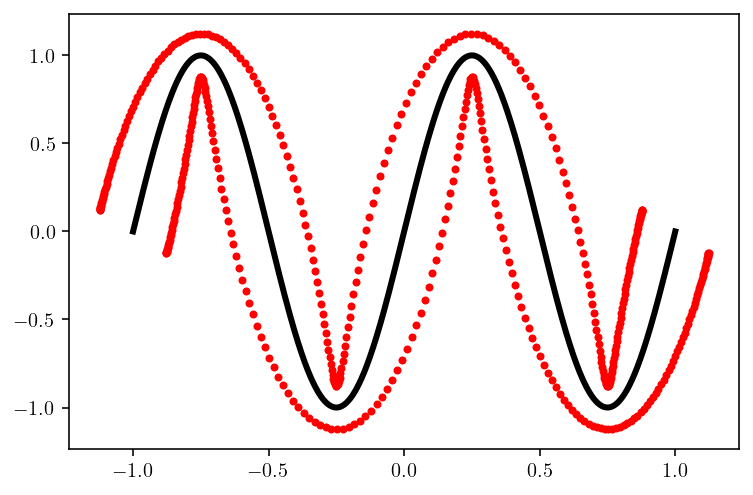

<ipython-input-7-4395429525d3>:95: RuntimeWarning: divide by zero encountered in log10
  logerror = np.log10(np.abs(disp_low - disp_high))


<ipython-input-7-4395429525d3>:125: RuntimeWarning: divide by zero encountered in log10
  logerror = np.log10(np.abs(disp_qbx - disp_high))


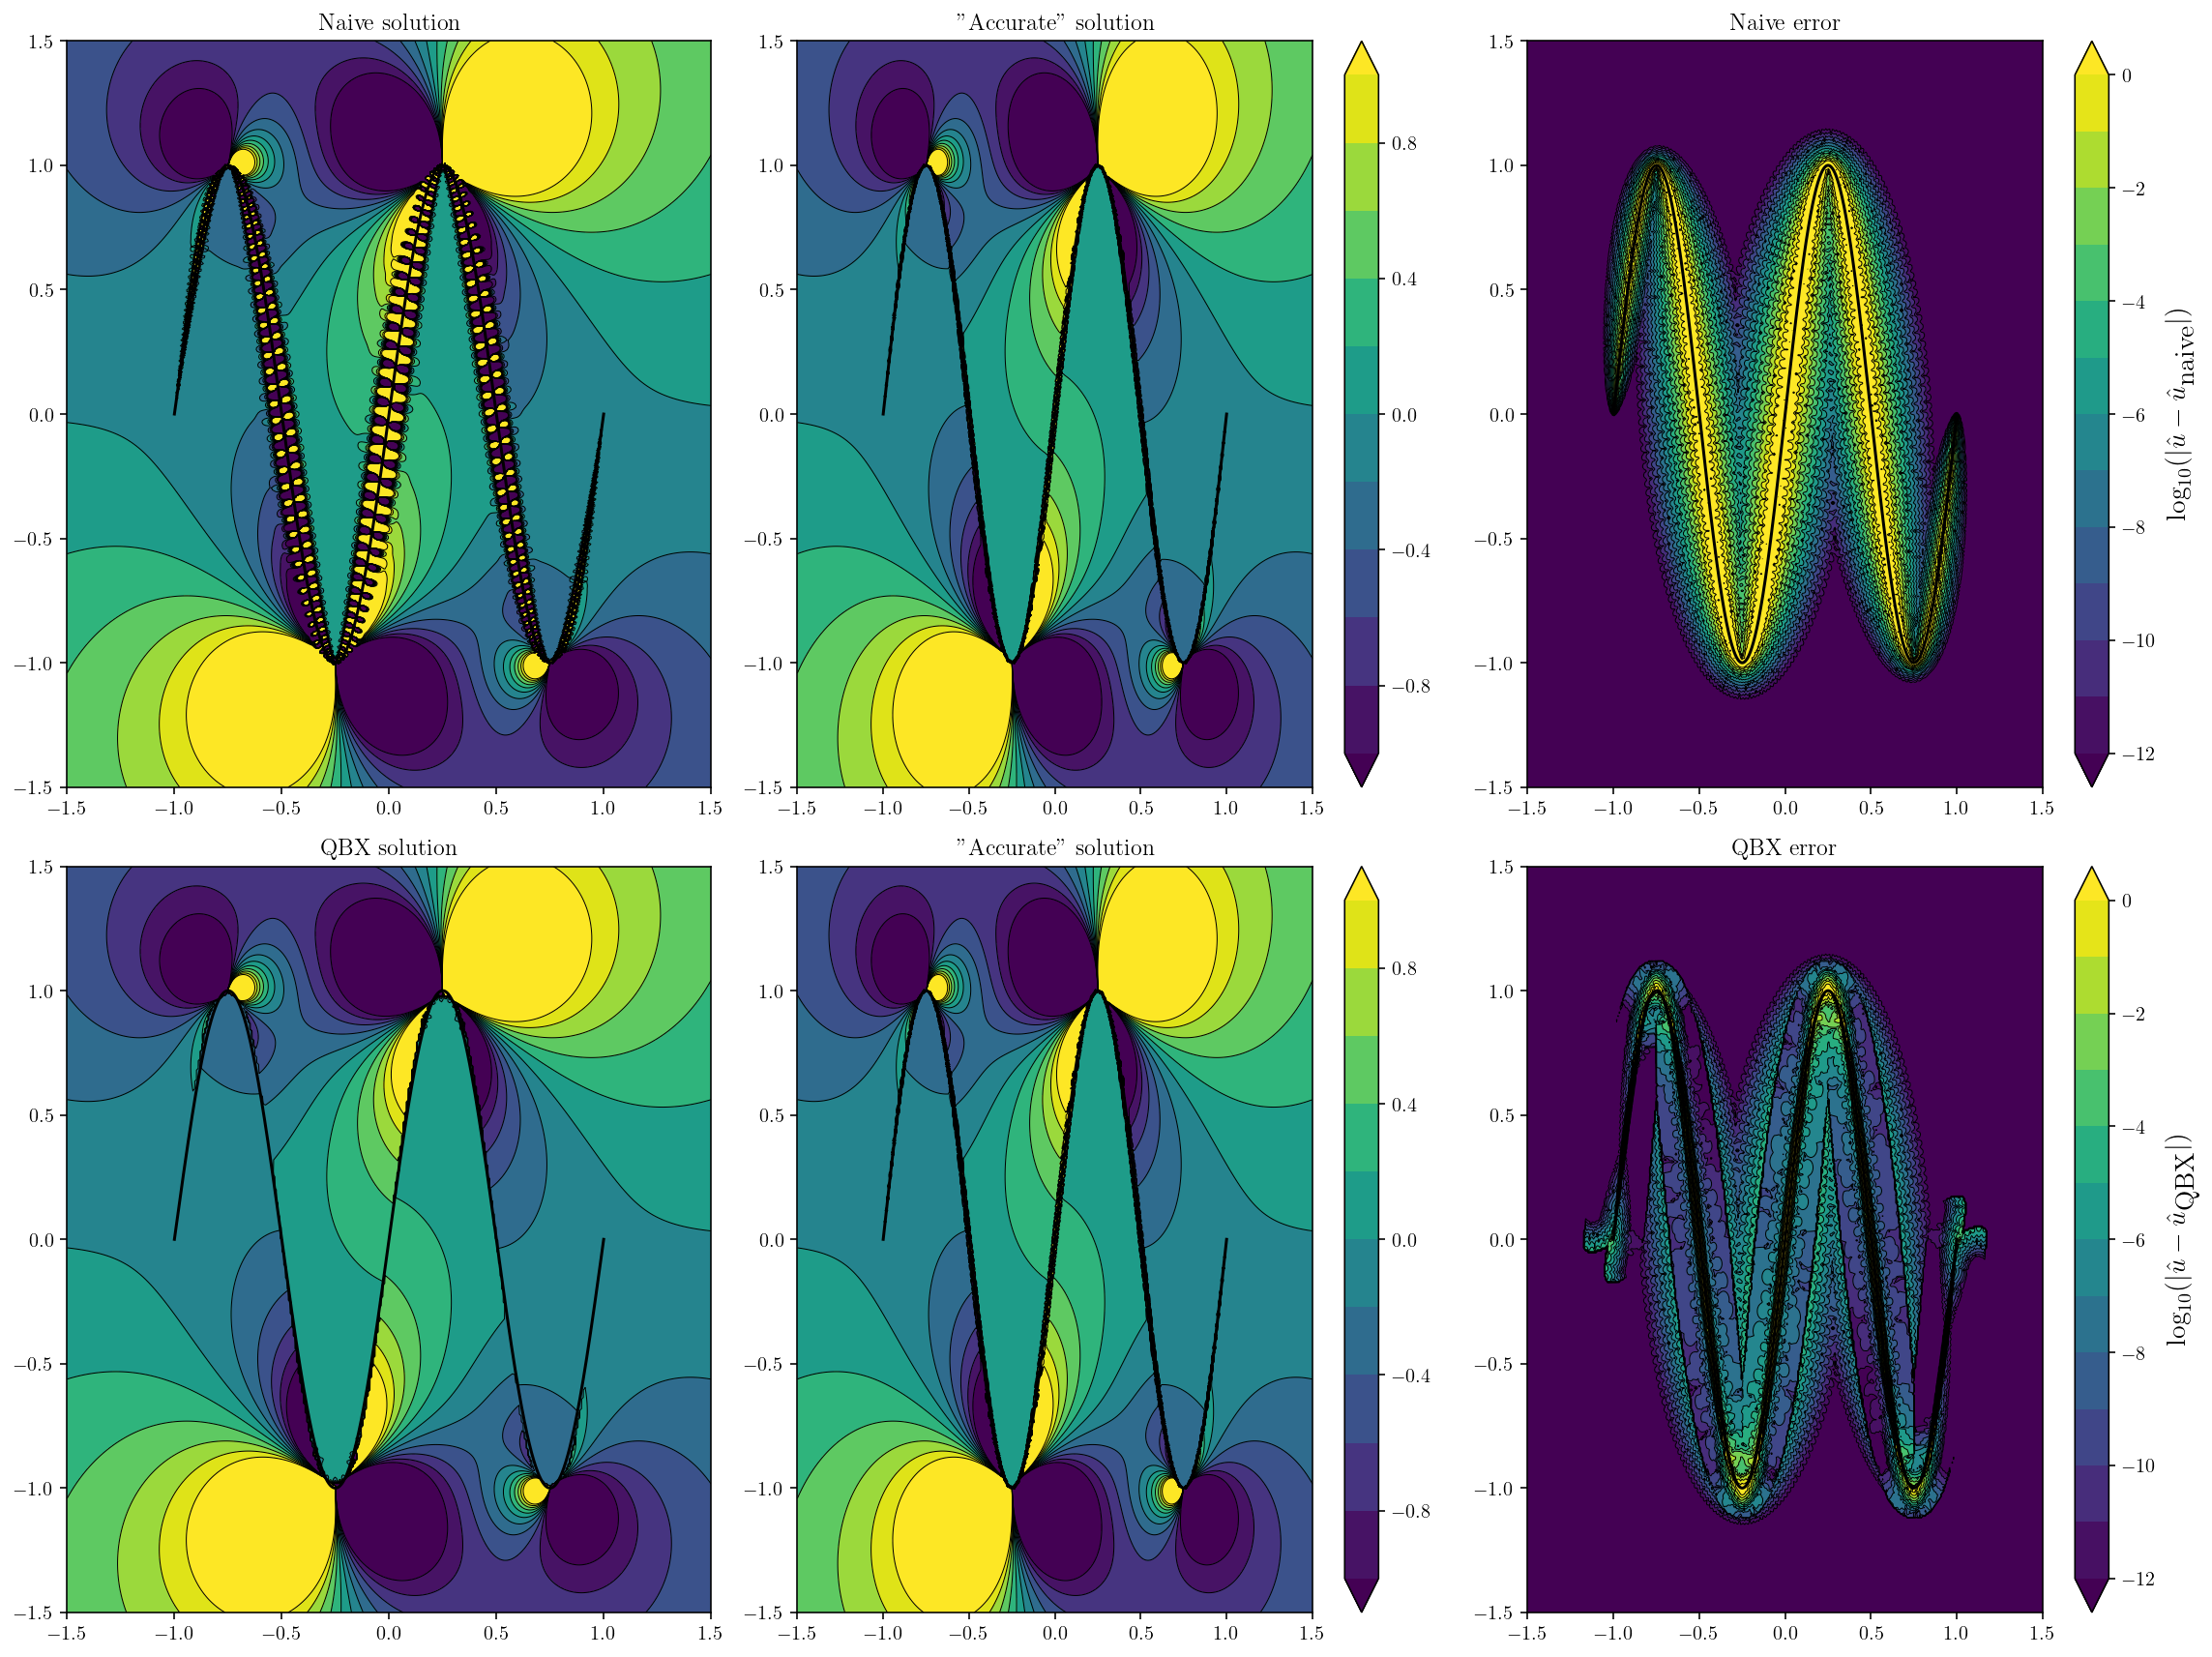

In [13]:
qbx_example(hypersingular_matrix, surface_fnc=wavy, n=256, offset_mult=2.5, kappa=5, qbx_p=15)